In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from batch_process import BatchProcess, FedBatchProcess
from pinn import PINN, numpy_to_tensor, train
from utils import get_data

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

# # Define kinetic parameters
# spyros_mu_max = 0.870
# spyros_K_s = 0.214
# spyros_Y_xs = 0.496

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


__Parameter estimation using PINN__

In [14]:
data = get_data(file_name='./data_processed.xlsx')
exp = data.index.unique()

df = data.loc['BR01']
df = df[df['Process']=='B']
print(f'Dataset shape: {df.shape}')

Dataset shape: (8, 8)


In [15]:
def plot_simulation(t, y, full_df, train_df, net_df):
    plt.figure(figsize=(10, 3))
    plt.plot(t, y[0], label='X')
    plt.plot(t, y[1], label='S')
    plt.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose', color='red', alpha=0.2)   
    plt.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass', color='green', alpha=0.2)
    plt.scatter(train_df['RTime'], train_df['Glucose'], marker='x', label='Glucose', color='red')   
    plt.scatter(train_df['RTime'], train_df['Biomass'], marker='x', label='Biomass', color='green')
    plt.scatter(net_df['RTime'], net_df['Glucose'], marker='+', label='Glucose', color='red', s=100, alpha=0.5)
    plt.scatter(net_df['RTime'], net_df['Biomass'], marker='+', label='Biomass', color='green', s=100, alpha=0.5)
    plt.legend()
    plt.show()
    
def simulate(df, mu_max, Ks, Yxs):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs
    
    def system_ode(t, y):
        X, S = y
        mu = mu_max * S / (Ks + S)
        dXdt = mu * X
        dSdt = - mu * X / Yxs
        return [dXdt, dSdt]
    
    t_eval = np.linspace(df['RTime'].min(), df['RTime'].max(), 10000)
    sol = solve_ivp(system_ode, [df['RTime'].min(), df['RTime'].max()], \
        [df['Biomass'].iloc[0], df['Glucose'].iloc[0]], t_eval=t_eval)
    return sol

Training using 2 data points
Initial mu_max: 0.5 | K_s: 0.5 | Y_xs: 0.5
Epoch 0 || Total Loss: 37.41
mu_max: 0.454133, Ks: 0.611043, Yxs: 0.3493


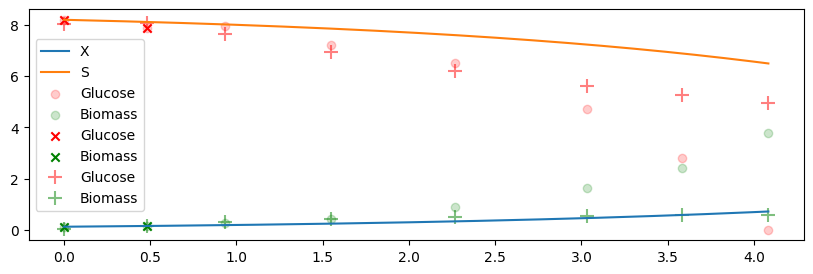

Training using 3 data points
Initial mu_max: 0.5 | K_s: 0.5 | Y_xs: 0.5
Epoch 0 || Total Loss: 40.25
mu_max: 0.441053, Ks: 0.600392, Yxs: 0.4545


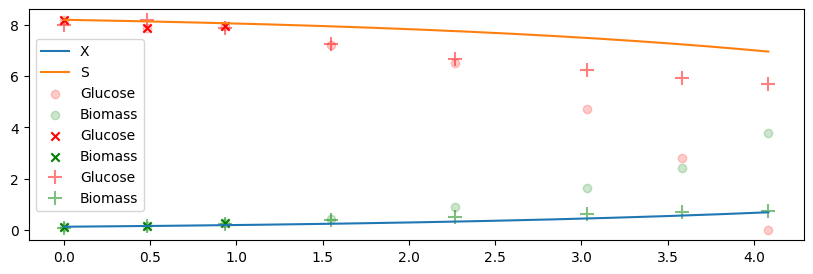

Training using 4 data points
Initial mu_max: 0.5 | K_s: 0.5 | Y_xs: 0.5
Epoch 0 || Total Loss: 38.95
mu_max: 0.508784, Ks: 0.619997, Yxs: 0.3035


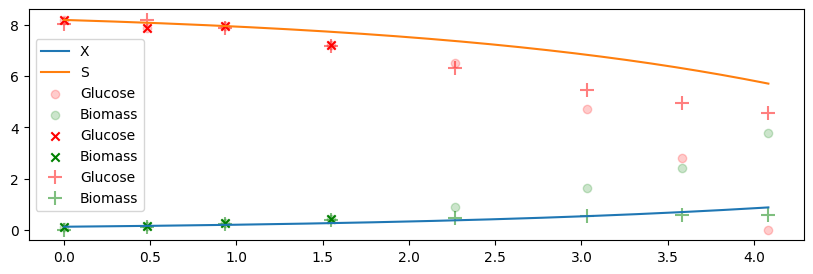

Training using 5 data points
Initial mu_max: 0.5 | K_s: 0.5 | Y_xs: 0.5
Epoch 0 || Total Loss: 37.99
mu_max: 0.447414, Ks: 0.598696, Yxs: 0.4870


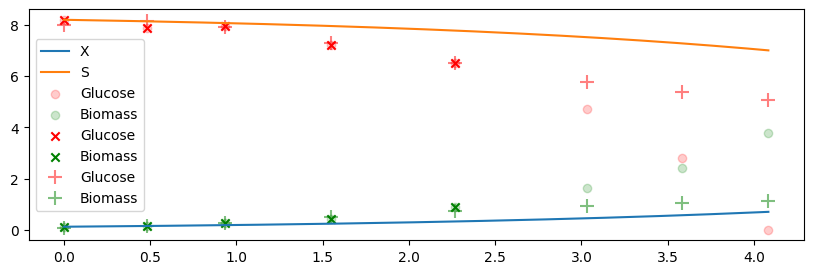

Training using 6 data points
Initial mu_max: 0.5 | K_s: 0.5 | Y_xs: 0.5
Epoch 0 || Total Loss: 35.36
Epoch 100 || Total Loss: 0.10
mu_max: 0.429783, Ks: 0.748731, Yxs: 0.3340


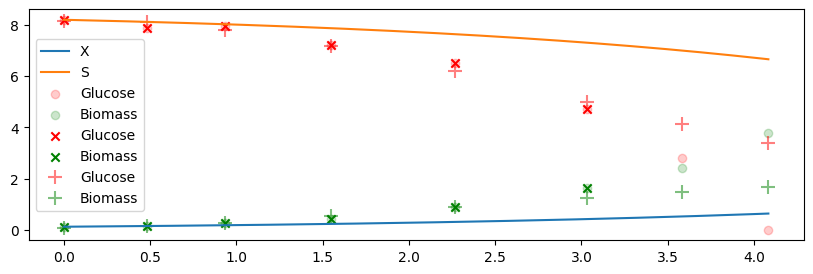

Training using 7 data points
Initial mu_max: 0.5 | K_s: 0.5 | Y_xs: 0.5
Epoch 0 || Total Loss: 29.62
Epoch 100 || Total Loss: 0.13
Epoch 200 || Total Loss: 0.10
Epoch 300 || Total Loss: 0.09
mu_max: 0.554155, Ks: 1.161745, Yxs: 0.3308


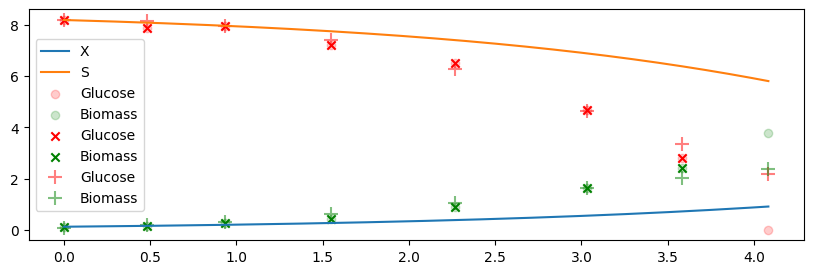

Training using 8 data points
Initial mu_max: 0.5 | K_s: 0.5 | Y_xs: 0.5
Epoch 0 || Total Loss: 28.64
Epoch 100 || Total Loss: 0.42
Epoch 200 || Total Loss: 0.30
Epoch 300 || Total Loss: 0.20
Epoch 400 || Total Loss: 0.18
Epoch 500 || Total Loss: 0.15
Epoch 600 || Total Loss: 0.08
Epoch 700 || Total Loss: 0.09
mu_max: 0.884758, Ks: 1.067131, Yxs: 0.4214


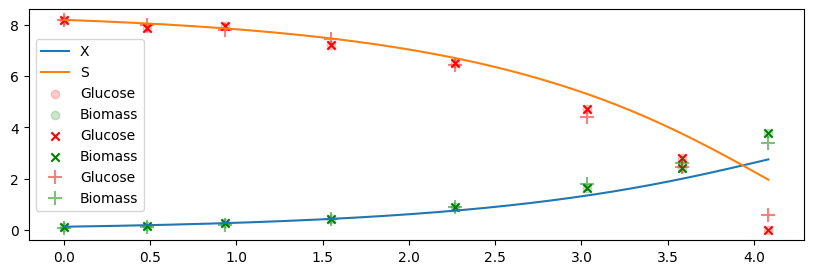

In [17]:
for i in range(2, len(df)+1):
    print(f'Training using {i} data points')
    
    _df = df.iloc[:i]
    t_start, t_end = _df['RTime'].min(), _df['RTime'].max()
    
    t = numpy_to_tensor(_df['RTime'].values)
    X = numpy_to_tensor(_df['Biomass'].values)
    S = numpy_to_tensor(_df['Glucose'].values)
    X_S = torch.cat((X, S), 1)
    
    net = PINN(1, 2, t_start=t_start, t_end=t_end)     
    net, total_loss, loss_data, loss_ic, loss_ode = train(net, t, X_S, df)

    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    net_df['RTime'] = t_test
    t_test = numpy_to_tensor(t_test)
    net_df['Biomass'] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df['Glucose'] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    
    print(f'mu_max: {mu_max:4f}, Ks: {Ks:4f}, Yxs: {Yxs:.4f}')
    
    solution = simulate(df, mu_max, Ks, Yxs)
    plot_simulation(solution.t, solution.y, df, _df, net_df)

In [ ]:
data = get_data(file_name='./data_processed.xlsx')
exp = data.index.unique()

df = data.loc['BR01']
df = df[df['Process']=='B']

t = numpy_to_tensor(df['RTime'].values)
X = numpy_to_tensor(df['Biomass'].values)
S = numpy_to_tensor(df['Glucose'].values)
X_S = torch.cat((X, S), 1)

net = PINN(1, 2, t_start=df['RTime'].min(), t_end=df['RTime'].max())

net, total_loss, loss_data, loss_ic, loss_ode = train(net, t, X_S, df)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(total_loss, label='Total loss')
plt.plot(loss_data, label='Data loss')
plt.plot(loss_ic, label='Initial condition loss')
plt.plot(loss_ode, label='ODE loss')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
np.mean(total_loss), np.mean(loss_data), np.mean(loss_ic), np.mean(loss_ode)

In [ ]:
net.get_params()

In [ ]:
net.forward(t)

In [ ]:
df[['Biomass', 'Glucose']]